In [72]:
import pandas as pd
import numpy as np
import matplotlib as plt
from pandas import Timestamp
from datetime import datetime, timedelta

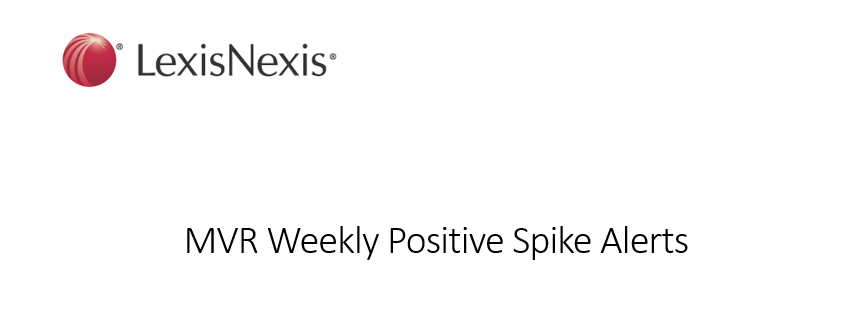

# Alerts Overview  


## 1. Population Criteria:
- accounts with past 7 weeks total units above 400 units 

## 2. Calculate a high value alert threshold based on past 12 weeks
- current week units > avg_12week_units + 4* std_12week_units


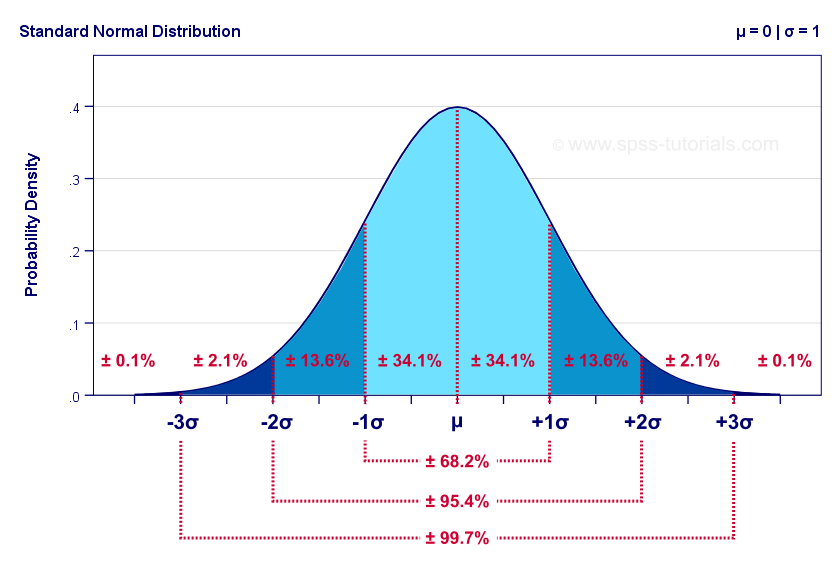


## 3. Dashboard Example 

https://app.powerbi.com/groups/072caada-ea85-40da-ba6f-9a73b6b9c99e/reports/ea34c4ab-4cf3-473c-bae3-2480f5671eca/ReportSection

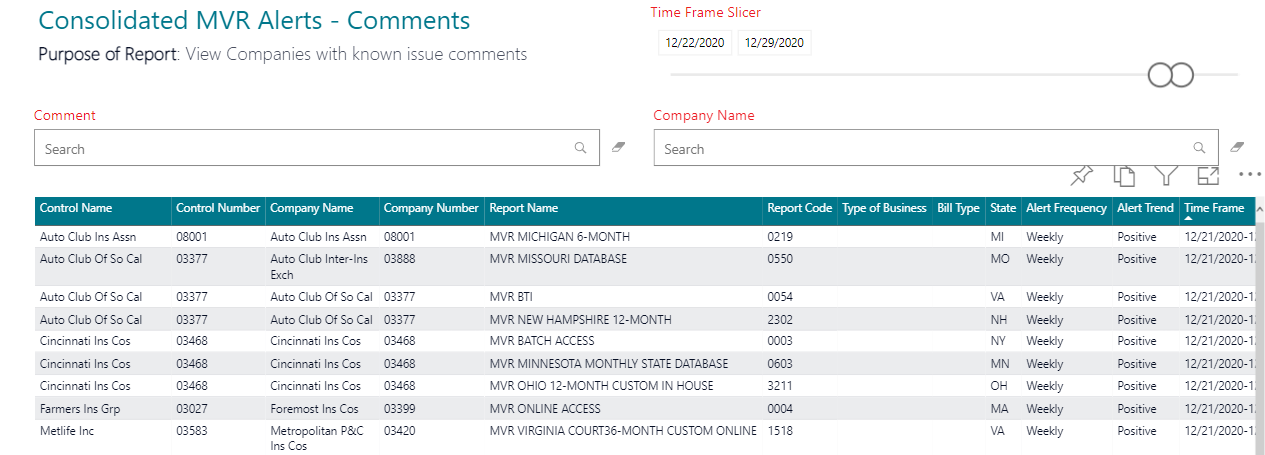

# Step 1: connect to SQL 

## 1.1. Import pyodbc: pyodbc is an open source Python module that makes accessing databases simple.

## 1.2. Set up server info, username, password, then connect to the SQL

## 1.3. Start your SQL queries
    

### Import pyodbc library


In [2]:
import pyodbc


In [3]:
server = 'fidosqldb.risk.regn.net,50750'
database = 'red' # enter database name
username = 'pasl_fidoanalytics'
password = 'H8o0T1saPuC' # add appropriate driver name
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()


### SQL queries 

In [4]:
query = ''' 
select o.date_sk, c.ins_control_name, c.ins_company_name, c.ins_company_nbr,  p.product_name, s.search_type_name,s.search_type_id, g.geography_sk, g.country, g.state_province_name, 
sum(o.unit_count) as total_units

FROM  fact_mvr_ops o
left join dim_search_type s on o.search_type_sk=s.search_type_sk
left join dim_date d on d.date_sk=o.date_sk
left join dim_geography g on o.geography_sk=g.geography_sk
left join dim_customer_account c on c.customer_account_sk = o.customer_account_sk
left join dim_product p on p.product_sk = o.product_sk
where 
c.ins_company_name not in ('', 'Lexisnexis Test Accts')  and o.product_sk = 84 
and c.mbs_product_id = 9 
and o.scenario_sk in (1,2,3)
and s.search_type_name not in ('MVR FLORIDA 1-MONTH CUSTOM', 
                                 'MVR GEORGIA 1-MONTH',
                                 'MVR IDAHO 1-MONTH',
                                'MVR IOWA 1-MONTH CUSTOM',
                                'MVR KANSAS 1-MONTH',
                                 'MVR MAINE 1-MONTH CUSTOM',
                                  'MVR MICHIGAN 1-MONTH',
                                   'MVR MONTANA 1-MONTH',
                                  'MVR NEBRASKA 1-MONTH',
                                  'MVR NEVADA 1-MONTH',
                                   'MVR NEW HAMPSHIRE 1-MONTH CUSTOM',
                                    'MVR NEW YORK 1-MONTH',
                                   'MVR OHIO 1-MONTH CUSTOM',
                                  'MVR UTAH 1-MONTH',
                                  'MVR VERMONT 1-MONTH CUSTOM')
and d.date_sk >= '20200706' and d.date_sk <= '20201227'  
group by o.date_sk, c.ins_control_name ,   c.ins_company_name, c.ins_company_nbr,  p.product_name, s.search_type_name,s.search_type_id, g.geography_sk, g.country, g.state_province_name

''';


data = pd.read_sql(query, cnxn)
data.head()

,date_sk,ins_control_name,ins_company_name,ins_company_nbr,product_name,search_type_name,search_type_id,geography_sk,country,state_province_name,total_units
0,20200729,Victor O Schinnerer Mga,Victor O Schinnerer Mga,30425,Motor Vehicle Records,MVR ONLINE ACCESS,0004,27,USA,Montana,4.0
1,20200709,Gerber Life Insurance Company,Gerber Life Insurance Company,98525,Motor Vehicle Records,MVR EDIT REJECT ONLINE,0214,23,USA,Michigan,2.0
2,20200727,NATIONAL GENERAL HOLDINGS CORP,NATIONAL GENERAL HOLDINGS CORP,07049,Motor Vehicle Records,MVR NATIONAL VIOLATION SEARCH 36-MONTH ONLINE,1474,24,USA,Minnesota,12.0
3,20200721,Mercury Gen Grp,Mercury Gen Grp,03401,Motor Vehicle Records,MVR ONLINE ACCESS AGENT,2049,32,USA,New Jersey,14.0
4,20200714,United Fire & Cas,United Fire & Cas,30238,Motor Vehicle Records,MVR BATCH ACCESS,0003,36,USA,Ohio,10.0


### Check the size of the dataset 

In [5]:
data.shape

(2166873, 11)

In [6]:
df = pd.DataFrame(data['date_sk'].tolist(), columns = ['date_int']) 
# Pandas has a it's own datetime libraries
# df['dttm'] = df.apply(pd.to_datetime(df['date_int'].astype(str)).values, axis=1)
df['date_string'] = df['date_int'].astype(str) #df.apply(lambda row: str(row.date_int), axis=1)#'Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

# Step2: lable the # of week to each date 

## 2.1: Convert date in numeric format  to standard datetime
- For example, convert 20201227(numeric) to 20201227(string), then convert to 2020-12-27

## 2.2: Use isocalendar() function to find out the number of week of a year
- For example, 2020-12-27 belongs to the 52th week of the year

## 2.3: Set the current week as max_week, and locate the past 12 weeks from current week

In [7]:
min(data['date_sk'])

20200706

In [8]:
max(data['date_sk'])

20201227

In [9]:
data.shape

(2166873, 11)

In [10]:
# add col to convert to datetime
# func = lambda row: datetime.strptime(df['date_string'], '%m%d%y'), axis=1
df['dttm'] = df['date_string'].apply(lambda x: datetime.strptime(x, '%Y%m%d'))

In [11]:
#https://docs.python.org/3/library/datetime.html#datetime.date.isocalendar
#The ISO year consists of 52 or 53 full weeks, and where a week starts on a Monday and ends on a Sunday.
df['week'] = df['dttm'].apply(lambda x: x.isocalendar()[1])

In [13]:
max_week = max(df['week'])
max_week

52

In [14]:
df[df['week'] == max_week]

,date_int,date_string,dttm,week
77,20201222,20201222,2020-12-22,52
80,20201224,20201224,2020-12-24,52
103,20201221,20201221,2020-12-21,52
106,20201223,20201223,2020-12-23,52
253,20201221,20201221,2020-12-21,52
...,...,...,...,...
2166730,20201227,20201227,2020-12-27,52
2166802,20201221,20201221,2020-12-21,52
2166812,20201223,20201223,2020-12-23,52
2166814,20201226,20201226,2020-12-26,52


In [15]:
### Below code is simple but takes long time to run, 

#df['week_format'] = df.apply(lambda row: "Prior-Wk-{}".format(max(df['week'])-row.week) if row.week != max(df['week']) else "curr_week", axis=1)

In [16]:
### The fast alternative for above one line of code
week_reverse = df['week']
week_reverse2 = max(df['week']) - df['week']
date_reverse_str = week_reverse2.astype(str)
prior = ['Prior-Wk-']*df.shape[0]          
df['week_format'] = prior + date_reverse_str
df['week_format'] [df['week_format'] =='Prior-Wk-0'] = 'Current-Wk'

<ipython-input-16-a4cf41365019>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week_format'] [df['week_format'] =='Prior-Wk-0'] = 'Current-Wk'


In [63]:
df[df['week_format'] == 'Prior-Wk-1']

,date_int,date_string,dttm,week,week_format
32,20201215,20201215,2020-12-15,51,Prior-Wk-1
37,20201215,20201215,2020-12-15,51,Prior-Wk-1
78,20201218,20201218,2020-12-18,51,Prior-Wk-1
79,20201218,20201218,2020-12-18,51,Prior-Wk-1
101,20201217,20201217,2020-12-17,51,Prior-Wk-1
...,...,...,...,...,...
2166815,20201217,20201217,2020-12-17,51,Prior-Wk-1
2166817,20201220,20201220,2020-12-20,51,Prior-Wk-1
2166819,20201215,20201215,2020-12-15,51,Prior-Wk-1
2166820,20201218,20201218,2020-12-18,51,Prior-Wk-1


In [69]:
df.sort_values(by=['week_format'])

,date_int,date_string,dttm,week,week_format
1173044,20201221,20201221,2020-12-21,52,Current-Wk
84061,20201223,20201223,2020-12-23,52,Current-Wk
989479,20201221,20201221,2020-12-21,52,Current-Wk
1184819,20201223,20201223,2020-12-23,52,Current-Wk
812134,20201225,20201225,2020-12-25,52,Current-Wk
...,...,...,...,...,...
1468513,20201022,20201022,2020-10-22,43,Prior-Wk-9
234123,20201020,20201020,2020-10-20,43,Prior-Wk-9
587191,20201019,20201019,2020-10-19,43,Prior-Wk-9
105276,20201019,20201019,2020-10-19,43,Prior-Wk-9


In [19]:
data['week_format'] = df['week_format']
data.head()

,date_sk,ins_control_name,ins_company_name,ins_company_nbr,product_name,search_type_name,search_type_id,geography_sk,country,state_province_name,total_units,week_format
0,20200729,Victor O Schinnerer Mga,Victor O Schinnerer Mga,30425,Motor Vehicle Records,MVR ONLINE ACCESS,0004,27,USA,Montana,4.0,Prior-Wk-21
1,20200709,Gerber Life Insurance Company,Gerber Life Insurance Company,98525,Motor Vehicle Records,MVR EDIT REJECT ONLINE,0214,23,USA,Michigan,2.0,Prior-Wk-24
2,20200727,NATIONAL GENERAL HOLDINGS CORP,NATIONAL GENERAL HOLDINGS CORP,07049,Motor Vehicle Records,MVR NATIONAL VIOLATION SEARCH 36-MONTH ONLINE,1474,24,USA,Minnesota,12.0,Prior-Wk-21
3,20200721,Mercury Gen Grp,Mercury Gen Grp,03401,Motor Vehicle Records,MVR ONLINE ACCESS AGENT,2049,32,USA,New Jersey,14.0,Prior-Wk-22
4,20200714,United Fire & Cas,United Fire & Cas,30238,Motor Vehicle Records,MVR BATCH ACCESS,0003,36,USA,Ohio,10.0,Prior-Wk-23


# Step3: Calcualte total units for each week
## 3.1 Use pivot_table() function to calculate total units from current week to prior_week_12
## 3.2: merge all the results 

In [20]:
current_wk= pd.DataFrame(data[data['week_format'] == 'Current-Wk'].pivot_table(index=['ins_company_name', 
                                'ins_company_nbr','search_type_name', 'search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
current_wk.columns= ['Current_Wk_units']
current_wk

Current_Wk_units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                  
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         24.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                          4.0
                                                                                                    Illinois                          6.0
                                                                                                    South Dakota                      8.0
                                                                                                    Wisconsin                        18.0
...                                                                                                                                   ...
iptiQ Americas, Inc. 96665           MVR TEXAS COURT 36-MONTH CUSTOM ONLINE          1945           Texas                            78.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                         56.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       32.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    12.0
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                           2.0

[23697 rows x 1 columns]

In [21]:
Prior_WK_1= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-1'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_1.columns= ['Prior_WK_1_Units']
Prior_WK_1

Prior_WK_1_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                  
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          2.0
                                     MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         28.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                          2.0
                                                                                                    Illinois                          4.0
                                                                                                    South Dakota                     16.0
...                                                                                                                                   ...
iptiQ Americas, Inc. 96665           MVR TEXAS COURT 36-MONTH CUSTOM ONLINE          1945           Texas                           182.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                         62.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       56.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    14.0
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                           4.0

[27724 rows x 1 columns]

In [22]:
Prior_WK_2= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-2'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_2.columns= ['Prior_WK_2_Units']
Prior_WK_2

Prior_WK_2_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                  
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         22.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                          4.0
                                                                                                    Illinois                         10.0
                                                                                                    South Dakota                      2.0
                                                                                                    Wisconsin                        10.0
...                                                                                                                                   ...
iptiQ Americas, Inc. 96665           MVR TEXAS COURT 36-MONTH CUSTOM ONLINE          1945           Texas                           146.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                         82.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       50.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    18.0
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                           2.0

[28095 rows x 1 columns]

In [23]:
frame0 = [current_wk,Prior_WK_1,Prior_WK_2 ]
result0 = pd.concat(frame0,axis=1, sort=False)
result0.head(10)

Current_Wk_units  \
ins_company_name   ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins 20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          NaN   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         24.0   
                                   MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                          4.0   
                                                                                                  Illinois                          6.0   
                                                                                                  South Dakota                      8.0   
                                                                                                  Wisconsin                        18.0   
                                   MVR DRIVER HISTORY DATABASE ONLINE AGENT        0568           Arkansas                          NaN   
                                                                                                  Illinois                          NaN   
                                                                                                  Nebraska                          2.0   
                                                                                                  South Dakota                     26.0   

                                                                                                                       Prior_WK_1_Units  \
ins_company_name   ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins 20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          2.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         28.0   
                                   MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                          2.0   
                                                                                                  Illinois                          4.0   
                                                                                                  South Dakota                     16.0   
                                                                                                  Wisconsin                        10.0   
                                   MVR DRIVER HISTORY DATABASE ONLINE AGENT        0568           Arkansas                          NaN   
                                                                                                  Illinois                          2.0   
                                                                                                  Nebraska                          2.0   
                                                                                                  South Dakota                     32.0   

                                                                                                                       Prior_WK_2_Units  
ins_company_name   ins_company_nbr search_type_name                                search_type_id state_province_name                    
1St Auto & Cas Ins 20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          NaN  
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         22.0  
                                   MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                          4.0  
                                                                                           

In [24]:
result0.shape

(37450, 3)

In [25]:
Prior_WK_3= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-3'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_3.columns= ['Prior_WK_3_Units']
Prior_WK_3

Prior_WK_3_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                  
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          2.0
                                     MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          2.0
                                     MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         58.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                          4.0
                                                                                                    Illinois                         12.0
...                                                                                                                                   ...
iptiQ Americas, Inc. 96665           MVR TENNESSEE 36-MONTH ONLINE                   0264           Tennessee                        32.0
                                     MVR TEXAS COURT 36-MONTH CUSTOM ONLINE          1945           Texas                           150.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                        106.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       48.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    30.0

[28491 rows x 1 columns]

In [26]:
Prior_WK_4= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-4'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_4.columns= ['Prior_WK_4_Units']
Prior_WK_4

Prior_WK_4_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                  
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         16.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                          2.0
                                                                                                    Illinois                          2.0
                                                                                                    South Dakota                      6.0
                                                                                                    Wisconsin                        16.0
...                                                                                                                                   ...
iptiQ Americas, Inc. 96665           MVR UTAH 60-MONTH COURT CUSTOM ONLINE           1267           Utah                              2.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                         60.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       36.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    14.0
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                           4.0

[24292 rows x 1 columns]

In [27]:
Prior_WK_5= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-5'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_5.columns= ['Prior_WK_5_Units']
Prior_WK_5

Prior_WK_5_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                  
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         32.0
                                     MVR DRIVER HISTORY DATABASE AGENT               0560           Kansas                            2.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                          4.0
                                                                                                    Illinois                          6.0
                                                                                                    South Dakota                     14.0
...                                                                                                                                   ...
iptiQ Americas, Inc. 96665           MVR TEXAS COURT 36-MONTH CUSTOM ONLINE          1945           Texas                           130.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                         70.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       46.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    22.0
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                           8.0

[28157 rows x 1 columns]

In [28]:
Prior_WK_6= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-6'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_6.columns= ['Prior_WK_6_Units']
Prior_WK_6

Prior_WK_6_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                  
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          2.0
                                     MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         32.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Illinois                         14.0
                                                                                                    Kansas                            2.0
                                                                                                    South Dakota                     16.0
...                                                                                                                                   ...
iptiQ Americas, Inc. 96665           MVR TEXAS COURT 36-MONTH CUSTOM ONLINE          1945           Texas                           100.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                         44.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       32.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    12.0
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                           2.0

[28244 rows x 1 columns]

In [29]:
Prior_WK_7= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-7'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_7.columns= ['Prior_WK_7_Units']
Prior_WK_7

Prior_WK_7_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                  
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         48.0
                                     MVR COLORADO ONLINE AGENT                       2089           Colorado                          2.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                          4.0
                                                                                                    Illinois                         10.0
                                                                                                    South Dakota                     10.0
...                                                                                                                                   ...
iptiQ Americas, Inc. 96665           MVR UTAH 60-MONTH COURT CUSTOM ONLINE           1267           Utah                              2.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                         60.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       38.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    10.0
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                           4.0

[28275 rows x 1 columns]

In [30]:
Prior_WK_8= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-8'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_8.columns= ['Prior_WK_8_Units']
Prior_WK_8

Prior_WK_8_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                  
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         28.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Illinois                          2.0
                                                                                                    South Dakota                      4.0
                                                                                                    Wisconsin                         8.0
                                     MVR DRIVER HISTORY DATABASE ONLINE AGENT        0568           Arkansas                          2.0
...                                                                                                                                   ...
iptiQ Americas, Inc. 96665           MVR TENNESSEE 36-MONTH ONLINE                   0264           Tennessee                        44.0
                                     MVR TEXAS COURT 36-MONTH CUSTOM ONLINE          1945           Texas                           104.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                         52.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       32.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    20.0

[27979 rows x 1 columns]

In [31]:
Prior_WK_9= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-9'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_9.columns= ['Prior_WK_9_Units']
Prior_WK_9

Prior_WK_9_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                  
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         22.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                          2.0
                                                                                                    Illinois                          2.0
                                                                                                    South Dakota                     14.0
                                                                                                    Wisconsin                        22.0
...                                                                                                                                   ...
iptiQ Americas, Inc. 96665           MVR TEXAS COURT 36-MONTH CUSTOM ONLINE          1945           Texas                            98.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                         56.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       36.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    16.0
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                           6.0

[28372 rows x 1 columns]

In [32]:
Prior_WK_10= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-10'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_10.columns= ['Prior_WK_10_Units']
Prior_WK_10

Prior_WK_10_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                   
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                           8.0
                                     MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                          44.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Illinois                           6.0
                                                                                                    South Dakota                      14.0
                                                                                                    Wisconsin                         14.0
...                                                                                                                                    ...
iptiQ Americas, Inc. 96665           MVR UTAH 60-MONTH COURT CUSTOM ONLINE           1267           Utah                               2.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                          58.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                        54.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                      6.0
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                            2.0

[28155 rows x 1 columns]

In [33]:
Prior_WK_11= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-11'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_11.columns= ['Prior_WK_11_Units']
Prior_WK_11

Prior_WK_11_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                   
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                           2.0
                                     MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                          80.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Illinois                           8.0
                                                                                                    South Dakota                       8.0
                                                                                                    Wisconsin                         14.0
...                                                                                                                                    ...
iptiQ Americas, Inc. 96665           MVR TEXAS COURT 36-MONTH CUSTOM ONLINE          1945           Texas                            118.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                          58.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                        30.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                     14.0
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                            6.0

[28496 rows x 1 columns]

In [34]:
Prior_WK_12= pd.DataFrame(data[data['week_format'] == 'Prior-Wk-12'].pivot_table(index=['ins_company_name', 'ins_company_nbr','search_type_name','search_type_id','state_province_name'],
               margins=False,
               #margins_name='total',  # defaults to 'All'
                values=['total_units'],
               aggfunc={'total_units':np.sum}))
Prior_WK_12.columns= ['Prior_WK_12_Units']
Prior_WK_12

Prior_WK_12_Units
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                   
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          10.0
                                     MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                          46.0
                                     MVR DRIVER HISTORY DATABASE ONLINE              2309           Arkansas                           2.0
                                                                                                    Illinois                           4.0
                                                                                                    South Dakota                      10.0
...                                                                                                                                    ...
iptiQ Americas, Inc. 96665           MVR TENNESSEE 36-MONTH ONLINE                   0264           Tennessee                         38.0
                                     MVR TEXAS COURT 36-MONTH CUSTOM ONLINE          1945           Texas                            104.0
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                          68.0
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                        38.0
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                      6.0

[28746 rows x 1 columns]

## merge 12 weeks calculation

In [ ]:
 

frames = [current_wk, Prior_WK_1, Prior_WK_2,Prior_WK_3,Prior_WK_4,Prior_WK_5,Prior_WK_6,Prior_WK_7,Prior_WK_8,Prior_WK_9,Prior_WK_10,Prior_WK_11,Prior_WK_12]

In [36]:
result2 = pd.concat(frames,axis=1, sort=False)
result3 = pd.DataFrame(result2).fillna(0)
result3.head()

Current_Wk_units  \
ins_company_name   ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins 20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          0.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          0.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         24.0   
                                   MVR COLORADO ONLINE AGENT                       2089           Colorado                          0.0   
                                   MVR DRIVER HISTORY DATABASE AGENT               0560           Kansas                            0.0   

                                                                                                                       Prior_WK_1_Units  \
ins_company_name   ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins 20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          0.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          2.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         28.0   
                                   MVR COLORADO ONLINE AGENT                       2089           Colorado                          0.0   
                                   MVR DRIVER HISTORY DATABASE AGENT               0560           Kansas                            0.0   

                                                                                                                       Prior_WK_2_Units  \
ins_company_name   ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins 20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          0.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          0.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         22.0   
                                   MVR COLORADO ONLINE AGENT                       2089           Colorado                          0.0   
                                   MVR DRIVER HISTORY DATABASE AGENT               0560           Kansas                            0.0   

                                                                                                                       Prior_WK_3_Units  \
ins_company_name   ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins 20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          2.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          2.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         58.0   
                                   MVR COLORADO ONLINE AGENT                       2089           Colorado                          0.0   
                                   MVR DRIVER HISTORY DATABASE AGENT               0560           Kansas                            0.0   

                                                                                                                       Prior_WK_4_Units  \
ins_company_name   ins_company_nbr search_type_name                                s

In [37]:
result3.shape

(58593, 13)

In [38]:
result4 = result3

In [39]:
result5 = result4.reset_index()

## Weekly total units results 

In [40]:
result5.head()

,ins_company_name,ins_company_nbr,search_type_name,search_type_id,state_province_name,Current_Wk_units,Prior_WK_1_Units,Prior_WK_2_Units,Prior_WK_3_Units,Prior_WK_4_Units,Prior_WK_5_Units,Prior_WK_6_Units,Prior_WK_7_Units,Prior_WK_8_Units,Prior_WK_9_Units,Prior_WK_10_Units,Prior_WK_11_Units,Prior_WK_12_Units
0,1St Auto & Cas Ins,20013,MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT,2975,Arkansas,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1St Auto & Cas Ins,20013,MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE,3598,Arkansas,0.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0,2.0,10.0
2,1St Auto & Cas Ins,20013,MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT,2985,Arkansas,24.0,28.0,22.0,58.0,16.0,32.0,32.0,48.0,28.0,22.0,44.0,80.0,46.0
3,1St Auto & Cas Ins,20013,MVR COLORADO ONLINE AGENT,2089,Colorado,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,1St Auto & Cas Ins,20013,MVR DRIVER HISTORY DATABASE AGENT,0560,Kansas,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
result4.shape

(58593, 13)

In [42]:
MVR_final = result3

# Step4: Calculating weekly positive spike alerts
## 4.1: Population Criteria: Only take accounts with total units in the past 7 weeks above 400 units 
## 4.2: Calculate average units of past 12 weeks for each accounts
## 4.3: Calculate standard deviations of past 12 weeks for each accounts
## 4.4: detect current week units > avg_12week_units + 4* std_12week_units


In [43]:
MVR_final.iloc[:, 1:8]

Prior_WK_1_Units  \
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          0.0   
                                     MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          2.0   
                                     MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         28.0   
                                     MVR COLORADO ONLINE AGENT                       2089           Colorado                          0.0   
                                     MVR DRIVER HISTORY DATABASE AGENT               0560           Kansas                            0.0   
...                                                                                                                                   ...   
iptiQ Americas, Inc. 96665           MVR UTAH 60-MONTH COURT CUSTOM ONLINE           1267           Utah                              0.0   
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                         62.0   
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       56.0   
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    14.0   
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                           4.0   

                                                                                                                         Prior_WK_2_Units  \
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          0.0   
                                     MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          0.0   
                                     MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         22.0   
                                     MVR COLORADO ONLINE AGENT                       2089           Colorado                          0.0   
                                     MVR DRIVER HISTORY DATABASE AGENT               0560           Kansas                            0.0   
...                                                                                                                                   ...   
iptiQ Americas, Inc. 96665           MVR UTAH 60-MONTH COURT CUSTOM ONLINE           1267           Utah                              0.0   
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE        1518           Virginia                         82.0   
                                     MVR WASHINGTON 36-MONTH CUSTOM ONLINE           4453           Washington                       50.0   
                                     MVR WEST VIRGINIA 36-MONTH ONLINE               0487           West Virginia                    18.0   
                                     MVR WYOMING 36-MONTH ONLINE                     0210           Wyoming                           2.0   

                                                                                                                         Prior_WK_3_Units  \
ins_company_name     ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins   20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          2.0   
                              

In [44]:
MVR_final['tot_7wk_adjunits'] = MVR_final.iloc[:, 1:8].sum(axis=1)
MVR_final.head()

Current_Wk_units  \
ins_company_name   ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins 20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          0.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          0.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         24.0   
                                   MVR COLORADO ONLINE AGENT                       2089           Colorado                          0.0   
                                   MVR DRIVER HISTORY DATABASE AGENT               0560           Kansas                            0.0   

                                                                                                                       Prior_WK_1_Units  \
ins_company_name   ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins 20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          0.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          2.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         28.0   
                                   MVR COLORADO ONLINE AGENT                       2089           Colorado                          0.0   
                                   MVR DRIVER HISTORY DATABASE AGENT               0560           Kansas                            0.0   

                                                                                                                       Prior_WK_2_Units  \
ins_company_name   ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins 20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          0.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          0.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         22.0   
                                   MVR COLORADO ONLINE AGENT                       2089           Colorado                          0.0   
                                   MVR DRIVER HISTORY DATABASE AGENT               0560           Kansas                            0.0   

                                                                                                                       Prior_WK_3_Units  \
ins_company_name   ins_company_nbr search_type_name                                search_type_id state_province_name                     
1St Auto & Cas Ins 20013           MVR ARKANSAS 36-MONTH COURT CUSTOM AGENT        2975           Arkansas                          2.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE       3598           Arkansas                          2.0   
                                   MVR ARKANSAS 36-MONTH COURT CUSTOM ONLINE AGENT 2985           Arkansas                         58.0   
                                   MVR COLORADO ONLINE AGENT                       2089           Colorado                          0.0   
                                   MVR DRIVER HISTORY DATABASE AGENT               0560           Kansas                            0.0   

                                                                                                                       Prior_WK_4_Units  \
ins_company_name   ins_company_nbr search_type_name                                s

In [ ]:
## Only keep dataset with 7 weeks total units >=400

In [45]:
MVR_final_adj = MVR_final[MVR_final['tot_7wk_adjunits'] >=400] 

In [46]:
MVR_final_adj                                                                                                                                                                                    

Current_Wk_units  \
ins_company_name     ins_company_nbr search_type_name                          search_type_id state_province_name                     
1St Auto & Cas Ins   20013           MVR ILLINOIS 6-MONTH CUSTOM ONLINE        5263           Illinois                        656.0   
                                     MVR ILLINOIS 60-MONTH CUSTOM ONLINE AGENT 5289           Illinois                         46.0   
                                     MVR IOWA 6-MONTH CUSTOM ONLINE            3750           Iowa                            274.0   
                                     MVR MISSIOURI ONLINE AGENT                0570           Missouri                        204.0   
                                     MVR MISSOURI DATABASE ONLINE              0551           Missouri                        734.0   
...                                                                                                                             ...   
iptiQ Americas, Inc. 96665           MVR ONLINE ACCESS                         0004           Michigan                         60.0   
                                                                                              Texas                           118.0   
                                     MVR PENNSYLVANIA 36-MONTH CUSTOM ONLINE   1781           Pennsylvania                     72.0   
                                     MVR TEXAS COURT 36-MONTH CUSTOM ONLINE    1945           Texas                            78.0   
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE  1518           Virginia                         56.0   

                                                                                                                   Prior_WK_1_Units  \
ins_company_name     ins_company_nbr search_type_name                          search_type_id state_province_name                     
1St Auto & Cas Ins   20013           MVR ILLINOIS 6-MONTH CUSTOM ONLINE        5263           Illinois                       1080.0   
                                     MVR ILLINOIS 60-MONTH CUSTOM ONLINE AGENT 5289           Illinois                        118.0   
                                     MVR IOWA 6-MONTH CUSTOM ONLINE            3750           Iowa                            470.0   
                                     MVR MISSIOURI ONLINE AGENT                0570           Missouri                        368.0   
                                     MVR MISSOURI DATABASE ONLINE              0551           Missouri                       1238.0   
...                                                                                                                             ...   
iptiQ Americas, Inc. 96665           MVR ONLINE ACCESS                         0004           Michigan                         98.0   
                                                                                              Texas                           168.0   
                                     MVR PENNSYLVANIA 36-MONTH CUSTOM ONLINE   1781           Pennsylvania                    140.0   
                                     MVR TEXAS COURT 36-MONTH CUSTOM ONLINE    1945           Texas                           182.0   
                                     MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE  1518           Virginia                         62.0   

                                                                                                                   Prior_WK_2_Units  \
ins_company_name     ins_company_nbr search_type_name                          search_type_id state_province_name                     
1St Auto & Cas Ins   20013           MVR ILLINOIS 6-MONTH CUSTOM ONLINE        5263           Illinois                        720.0   
                                     MVR ILLINOIS 60-MONTH CUSTOM ONLINE AGENT 5289           Illinois                        108.0   
                                     MVR IOWA 6-MONTH CUSTOM ON

## Calculating standard deviation for 12 weeks 

In [47]:
MVR_final_adj['12_wk_std'] = MVR_final_adj.iloc[:, 1:13].std(axis=1)

<ipython-input-47-d66e847abf95>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MVR_final_adj['12_wk_std'] = MVR_final_adj.iloc[:, 1:13].std(axis=1)


## Calculating average for 12 weeks 

In [71]:
MVR_final_adj['12_wk_mean'] = MVR_final_adj.iloc[:, 1:13].mean(axis=1)

<ipython-input-71-38c7e57e7e9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MVR_final_adj['12_wk_mean'] = MVR_final_adj.iloc[:, 1:13].mean(axis=1)


## Calculating positive spike alerts threshold: 12_week_mean + 4 * 12_week_std

In [49]:
MVR_final_adj['12_wk_std_4x'] = MVR_final_adj['12_wk_mean']+MVR_final_adj['12_wk_std']*4

<ipython-input-49-b3215ad234f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MVR_final_adj['12_wk_std_4x'] = MVR_final_adj['12_wk_mean']+MVR_final_adj['12_wk_std']*4


In [50]:
MVR_final_adj.to_csv('vijay_expected_results.csv', sep='\t', encoding='utf-8')

## Dectect how many accounts hit positive spike alerts threshold 

In [51]:
len(MVR_final_adj['Current_Wk_units'][MVR_final_adj['Current_Wk_units'] >MVR_final_adj['12_wk_std_4x']])

21

In [52]:
results = MVR_final_adj[MVR_final_adj['Current_Wk_units'] >MVR_final_adj['12_wk_std_4x']]


In [53]:
results.shape

(21, 17)

In [54]:
results

Current_Wk_units  \
ins_company_name              ins_company_nbr search_type_name                           search_type_id state_province_name                     
Auto Club Ins Assn            08001           MVR MICHIGAN 6-MONTH                       0219           Michigan                     105210.0   
Auto Club Inter-Ins Exch      03888           MVR MISSOURI DATABASE                      0550           Missouri                      25434.0   
Auto Club Of So Cal           03377           MVR BTI                                    0054           Virginia                        400.0   
                                              MVR NEW HAMPSHIRE 12-MONTH                 2302           New Hampshire                  1558.0   
Cincinnati Ins Cos            03468           MVR BATCH ACCESS                           0003           New York                        796.0   
                                              MVR MINNESOTA MONTHLY STATE DATABASE       0603           Minnesota                      1102.0   
                                              MVR OHIO 12-MONTH CUSTOM IN HOUSE          3211           Ohio                           1645.0   
Foremost Ins Cos              03399           MVR ONLINE ACCESS                          0004           Massachusetts                   226.0   
Harleysville Ins Cos          03257           MVR ONLINE ACCESS                          0004           New York                        204.0   
Horace Mann Ins Grp           03407           MVR NATIONAL VIOLATION SEARCH 12-MONTH     1469           Vermont                         488.0   
                                              MVR VERMONT 12-MONTH CUSTOM                3863           Vermont                         488.0   
Metropolitan P&C Ins Cos      03420           MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE   1518           Virginia                        410.0   
Selective Ins Grp             03265           MVR PENNSYLVANIA 36-MONTH CUSTOM           1780           Pennsylvania                   1086.0   
Tesla Insurance Services, Inc 91882           MVR CALIFORNIA 36-MONTH CUSTOM ONLINE      5805           California                    10006.0   
                                              MVR EDIT REJECT ONLINE                     0214           California                      562.0   
Travelers Ins                 03197           MVR OREGON 36-MONTH CUSTOM ONLINE          4241           Oregon                          486.0   
Usaa Grp                      03418           MVR BATCH ACCESS                           0003           Louisiana                      1446.0   
                                              MVR DELAWARE 36-MONTH  CUSTOM              1362           Delaware                       1320.0   
                                              MVR GEORGIA LRI  BATCH TO INTERACTIVE      3658           Georgia                        3004.0   
                                              MVR GEORGIA LRI CLEAR BATCH TO INTERACTIVE 3651           Georgia                       14142.0   
                                              MVR INDIANA 36-MONTH CUSTOM                1065           Indiana                        2834.0   

                                                                                                                             Prior_WK_1_Units  \
ins_company_name              ins_company_nbr search_type_name                           search_type_id state_province_name                     
Auto Club Ins Assn            08001           MVR MICHIGAN 6-MONTH                       0219           Michigan                      57270.0   
Auto Club Inter-Ins Exch      03888           MVR MISSOURI DATABASE                      0550           Missouri                       7494.0   
Auto Club Of So Cal           03377           MVR BTI                                    0054           Virginia                        160.0   
                                              MVR NEW HAMPSHIRE 

In [55]:
cols = [8,9,10,11,12,14,15,16]
results.drop(results.columns[cols],axis=1,inplace=True)

/var/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [56]:
results.head()

Current_Wk_units  \
ins_company_name         ins_company_nbr search_type_name           search_type_id state_province_name                     
Auto Club Ins Assn       08001           MVR MICHIGAN 6-MONTH       0219           Michigan                     105210.0   
Auto Club Inter-Ins Exch 03888           MVR MISSOURI DATABASE      0550           Missouri                      25434.0   
Auto Club Of So Cal      03377           MVR BTI                    0054           Virginia                        400.0   
                                         MVR NEW HAMPSHIRE 12-MONTH 2302           New Hampshire                  1558.0   
Cincinnati Ins Cos       03468           MVR BATCH ACCESS           0003           New York                        796.0   

                                                                                                        Prior_WK_1_Units  \
ins_company_name         ins_company_nbr search_type_name           search_type_id state_province_name                     
Auto Club Ins Assn       08001           MVR MICHIGAN 6-MONTH       0219           Michigan                      57270.0   
Auto Club Inter-Ins Exch 03888           MVR MISSOURI DATABASE      0550           Missouri                       7494.0   
Auto Club Of So Cal      03377           MVR BTI                    0054           Virginia                        160.0   
                                         MVR NEW HAMPSHIRE 12-MONTH 2302           New Hampshire                   658.0   
Cincinnati Ins Cos       03468           MVR BATCH ACCESS           0003           New York                        136.0   

                                                                                                        Prior_WK_2_Units  \
ins_company_name         ins_company_nbr search_type_name           search_type_id state_province_name                     
Auto Club Ins Assn       08001           MVR MICHIGAN 6-MONTH       0219           Michigan                      64526.0   
Auto Club Inter-Ins Exch 03888           MVR MISSOURI DATABASE      0550           Missouri                      17308.0   
Auto Club Of So Cal      03377           MVR BTI                    0054           Virginia                        258.0   
                                         MVR NEW HAMPSHIRE 12-MONTH 2302           New Hampshire                   914.0   
Cincinnati Ins Cos       03468           MVR BATCH ACCESS           0003           New York                        218.0   

                                                                                                        Prior_WK_3_Units  \
ins_company_name         ins_company_nbr search_type_name           search_type_id state_province_name                     
Auto Club Ins Assn       08001           MVR MICHIGAN 6-MONTH       0219           Michigan                      58948.0   
Auto Club Inter-Ins Exch 03888           MVR MISSOURI DATABASE      0550           Missouri                      10850.0   
Auto Club Of So Cal      03377           MVR BTI                    0054           Virginia                        212.0   
                                         MVR NEW HAMPSHIRE 12-MONTH 2302           New Hampshire                   758.0   
Cincinnati Ins Cos       03468           MVR BATCH ACCESS           0003           New York                        208.0   

                                                                                                        Prior_WK_4_Units  \
ins_company_name         ins_company_nbr search_type_name           search_type_id state_province_name                     
Auto Club Ins Assn       08001           MVR MICHIGAN 6-MONTH       0219           Michigan                      34966.0   
Auto Club Inter-Ins Exch 03888           MVR MISSOURI DATABASE      0550           Missouri                      16514.0   
Auto Club Of So Cal      03377           MVR BTI                    0054           Virginia                        210.0   
        

In [57]:
results['%Diff(2-WK-Avg)'] = (results['Current_Wk_units'] - results.iloc[:, 1:3].mean(axis = 1))/results.iloc[:, 1:3].mean(axis = 1) *100

<ipython-input-57-d8e0f3385ae4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['%Diff(2-WK-Avg)'] = (results['Current_Wk_units'] - results.iloc[:, 1:3].mean(axis = 1))/results.iloc[:, 1:3].mean(axis = 1) *100


In [58]:
results.iloc[:, 1:3]

Prior_WK_1_Units  \
ins_company_name              ins_company_nbr search_type_name                           search_type_id state_province_name                     
Auto Club Ins Assn            08001           MVR MICHIGAN 6-MONTH                       0219           Michigan                      57270.0   
Auto Club Inter-Ins Exch      03888           MVR MISSOURI DATABASE                      0550           Missouri                       7494.0   
Auto Club Of So Cal           03377           MVR BTI                                    0054           Virginia                        160.0   
                                              MVR NEW HAMPSHIRE 12-MONTH                 2302           New Hampshire                   658.0   
Cincinnati Ins Cos            03468           MVR BATCH ACCESS                           0003           New York                        136.0   
                                              MVR MINNESOTA MONTHLY STATE DATABASE       0603           Minnesota                       190.0   
                                              MVR OHIO 12-MONTH CUSTOM IN HOUSE          3211           Ohio                            823.0   
Foremost Ins Cos              03399           MVR ONLINE ACCESS                          0004           Massachusetts                   142.0   
Harleysville Ins Cos          03257           MVR ONLINE ACCESS                          0004           New York                         36.0   
Horace Mann Ins Grp           03407           MVR NATIONAL VIOLATION SEARCH 12-MONTH     1469           Vermont                           0.0   
                                              MVR VERMONT 12-MONTH CUSTOM                3863           Vermont                           0.0   
Metropolitan P&C Ins Cos      03420           MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE   1518           Virginia                        162.0   
Selective Ins Grp             03265           MVR PENNSYLVANIA 36-MONTH CUSTOM           1780           Pennsylvania                    332.0   
Tesla Insurance Services, Inc 91882           MVR CALIFORNIA 36-MONTH CUSTOM ONLINE      5805           California                     5086.0   
                                              MVR EDIT REJECT ONLINE                     0214           California                      228.0   
Travelers Ins                 03197           MVR OREGON 36-MONTH CUSTOM ONLINE          4241           Oregon                          292.0   
Usaa Grp                      03418           MVR BATCH ACCESS                           0003           Louisiana                       842.0   
                                              MVR DELAWARE 36-MONTH  CUSTOM              1362           Delaware                        644.0   
                                              MVR GEORGIA LRI  BATCH TO INTERACTIVE      3658           Georgia                        1020.0   
                                              MVR GEORGIA LRI CLEAR BATCH TO INTERACTIVE 3651           Georgia                        6470.0   
                                              MVR INDIANA 36-MONTH CUSTOM                1065           Indiana                        1518.0   

                                                                                                                             Prior_WK_2_Units  
ins_company_name              ins_company_nbr search_type_name                           search_type_id state_province_name                    
Auto Club Ins Assn            08001           MVR MICHIGAN 6-MONTH                       0219           Michigan                      64526.0  
Auto Club Inter-Ins Exch      03888           MVR MISSOURI DATABASE                      0550           Missouri                      17308.0  
Auto Club Of So Cal           03377           MVR BTI                                    0054           Virginia                        258.0  
                                              MVR NEW HAMPSHIRE 12-MO

In [59]:
results

Current_Wk_units  \
ins_company_name              ins_company_nbr search_type_name                           search_type_id state_province_name                     
Auto Club Ins Assn            08001           MVR MICHIGAN 6-MONTH                       0219           Michigan                     105210.0   
Auto Club Inter-Ins Exch      03888           MVR MISSOURI DATABASE                      0550           Missouri                      25434.0   
Auto Club Of So Cal           03377           MVR BTI                                    0054           Virginia                        400.0   
                                              MVR NEW HAMPSHIRE 12-MONTH                 2302           New Hampshire                  1558.0   
Cincinnati Ins Cos            03468           MVR BATCH ACCESS                           0003           New York                        796.0   
                                              MVR MINNESOTA MONTHLY STATE DATABASE       0603           Minnesota                      1102.0   
                                              MVR OHIO 12-MONTH CUSTOM IN HOUSE          3211           Ohio                           1645.0   
Foremost Ins Cos              03399           MVR ONLINE ACCESS                          0004           Massachusetts                   226.0   
Harleysville Ins Cos          03257           MVR ONLINE ACCESS                          0004           New York                        204.0   
Horace Mann Ins Grp           03407           MVR NATIONAL VIOLATION SEARCH 12-MONTH     1469           Vermont                         488.0   
                                              MVR VERMONT 12-MONTH CUSTOM                3863           Vermont                         488.0   
Metropolitan P&C Ins Cos      03420           MVR VIRGINIA COURT36-MONTH CUSTOM ONLINE   1518           Virginia                        410.0   
Selective Ins Grp             03265           MVR PENNSYLVANIA 36-MONTH CUSTOM           1780           Pennsylvania                   1086.0   
Tesla Insurance Services, Inc 91882           MVR CALIFORNIA 36-MONTH CUSTOM ONLINE      5805           California                    10006.0   
                                              MVR EDIT REJECT ONLINE                     0214           California                      562.0   
Travelers Ins                 03197           MVR OREGON 36-MONTH CUSTOM ONLINE          4241           Oregon                          486.0   
Usaa Grp                      03418           MVR BATCH ACCESS                           0003           Louisiana                      1446.0   
                                              MVR DELAWARE 36-MONTH  CUSTOM              1362           Delaware                       1320.0   
                                              MVR GEORGIA LRI  BATCH TO INTERACTIVE      3658           Georgia                        3004.0   
                                              MVR GEORGIA LRI CLEAR BATCH TO INTERACTIVE 3651           Georgia                       14142.0   
                                              MVR INDIANA 36-MONTH CUSTOM                1065           Indiana                        2834.0   

                                                                                                                             Prior_WK_1_Units  \
ins_company_name              ins_company_nbr search_type_name                           search_type_id state_province_name                     
Auto Club Ins Assn            08001           MVR MICHIGAN 6-MONTH                       0219           Michigan                      57270.0   
Auto Club Inter-Ins Exch      03888           MVR MISSOURI DATABASE                      0550           Missouri                       7494.0   
Auto Club Of So Cal           03377           MVR BTI                                    0054           Virginia                        160.0   
                                              MVR NEW HAMPSHIRE 

In [60]:
results1 = results.reset_index()

In [61]:
results1.to_csv('/home/autumn/MVR-Postive-Spike/Weekly_Reports/results_MVR_1227.csv', sep='\t', encoding='utf-8')